# KdV equation with adaptive sampling measure

In [1]:
import jax
import jax.numpy as jnp
import optax
from Data import *
from Plot import *
from NeuralNetwork import *
from InitialFit import *
from Solver import *
from Error import *
from JaxUtils import *

### Setup

In [2]:
# Exact solution

def exactKdVTwoSol(x, t):
    '''
    Function taken from https://github.com/pehersto/ng/solvers/exactKdV.py
    Args:
        x: jnp.array, points in space
        t: jnp.array (or float), points in time
    '''

    k = jnp.asarray([1., jnp.sqrt(5.)])
    eta = jnp.asarray([0., 10.73])
    t = jnp.asarray(t) # in case t is a float

    etaMat1 = k[0] * x.reshape((-1, 1)) - k[0] ** 3 * t.reshape((1, -1)) + eta[0]
    etaMat2 = k[1] * x.reshape((-1, 1)) - k[1] ** 3 * t.reshape((1, -1)) + eta[1]
    c = ((k[0] - k[1]) / (k[0] + k[1]) )** 2

    f = 1. + jnp.exp(etaMat1) + jnp.exp(etaMat2) + jnp.multiply(jnp.exp(etaMat1), jnp.exp(etaMat2) * c)
    df = k[0] * jnp.exp(etaMat1) + k[1] * jnp.exp(etaMat2) + c * (k[0] + k[1]) * jnp.multiply(jnp.exp(etaMat1), jnp.exp(etaMat2))
    ddf = k[0] ** 2 * jnp.exp(etaMat1) + k[1] ** 2 * jnp.exp(etaMat2) + c * (k[0] + k[1]) ** 2 * jnp.multiply(jnp.exp(etaMat1), jnp.exp(etaMat2))

    y = 2 * jnp.divide(jnp.multiply(f, ddf) - df ** 2, f ** 2)

    y = jnp.nan_to_num(y, nan=0.0, posinf=0.0, neginf=0.0) # avoid numerical errors far outside of [-1, 2]
    
    return y

In [3]:
problem_data = ProblemData(name='kdv_adaptive', # problem name
                           d=1, # input dimension
                           domain=(-20, 40), # 1D: (lower, upper)
                           T=4, # 6, # final time
                           initial_fn=lambda x: exactKdVTwoSol(x, 0), # initial condition
                           N=2048, # number of spatial points
                           dt=0.01, # time step (if needed)
                          )

training_data = TrainingData(m=5, # number of neurons per layer
                             batch_size=100000, # batch size
                             epochs=100000, # number of epochs
                             gamma=0.1, # learning rate (if needed)
                             seed=0, # seed for reproducibility
                             scheduler=optax.piecewise_constant_schedule(init_value=0.1, boundaries_and_scales={1000: 0.1, 10000: 0.1}) # learning rate scheduler
                             # scheduler=optax.piecewise_constant_schedule(init_value=0.1, boundaries_and_scales={100: 0.5, 1000: 0.5, 10000: 0.5}) # learning rate scheduler
                             # scheduler=optax.exponential_decay(init_value=0.1, transition_steps=1000, decay_rate=0.9) # learning rate scheduler
                             # scheduler=optax.linear_schedule(init_value=0.1, end_value=0.01, 
                             #                                 transition_steps=1000, transition_begin=1000) # learning rate scheduler
                            )

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


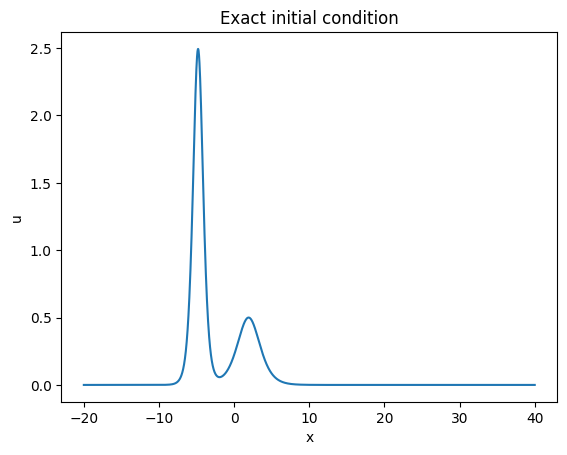

In [4]:
plot_function(problem_data.initial_fn, problem_data, 'Exact initial condition')

In [5]:
print(problem_data)

Problem data:
  name: kdv_adaptive, d: 1, domain: (-20, 40), T: 4, N: 2048, dt: 0.01


In [6]:
print(training_data)

Training data:
  m: 5, batch size: 100000, epochs: 100000, gamma: 0.1, seed: 0, scheduler: <function piecewise_constant_schedule.<locals>.schedule at 0x7fbfbc2a84c0>


### Initial fit

In [7]:
# Neural network

net = DeepNetKdV(training_data.m)
print(net)

DeepNetKdV(
    # attributes
    m = 5
)


In [8]:
# Initial fit

initial_fit = False

if initial_fit:
    theta = init_neural_galerkin(net, problem_data, training_data) # train a NN to fit the initial condition
    jnp.save('./data/theta_init_' + problem_data.name + '_' + str(training_data.seed) + '.npy', theta)
else:
    theta = jnp.load('./data/theta_init_' + problem_data.name + '_' + str(training_data.seed) + '_improved.npy', allow_pickle=True).item()

x_plot = jnp.linspace(problem_data.domain[0], problem_data.domain[1], problem_data.N)
relative_error = jnp.linalg.norm(net.apply(theta, x_plot.reshape(-1, 1)) - exactKdVTwoSol(x_plot, 0)) / jnp.linalg.norm(exactKdVTwoSol(x_plot, 0))
print("Relative error of the initial fit:", relative_error)

Relative error of the initial fit: 0.00047301722


In [9]:
# Further improve the initial fit (elapsed time: 2h30)

# training_data.epochs = 400000 # 500k epochs in total
# training_data.gamma = 1e-4
# training_data.scheduler = None
# theta = init_neural_galerkin(net, problem_data, training_data, theta)
# jnp.save('./data/theta_init_' + problem_data.name + '_' + str(training_data.seed) + '_improved.npy', theta)

### Time evolution

In [9]:
theta_flat, unravel = jax.flatten_util.ravel_pytree(theta) # flatten a pytree of arrays down to a 1D array
u_fn = unraveler(net.apply, unravel) # auxiliary function that allows to evaluate the NN starting from the flattened parameters

# Define gradients
U = jax.vmap(u_fn, (None, 0)) # jax.vmap(fun, in_axes)
U_dtheta = jax.vmap(jax.grad(u_fn), (None, 0))
U_dx = jax.vmap(gradsqz(u_fn, 1), (None, 0))
U_dddx = jax.vmap(gradsqz(gradsqz(gradsqz(u_fn, 1), 1), 1), (None, 0))

In [11]:
print(theta_flat)

[ -3.4388554  -11.72195     -2.8828      -1.2034398    8.7858925
   0.97160673  -2.1526647    1.1344683    0.95950127   2.1134155
  -0.6000323   -0.29816905   2.0424507    2.5361478    0.2880458
  -0.5474185    0.1896016   -1.0142356   -1.0601054   -0.77138186
  -2.178971     2.1520314   -7.53925     -3.785715    -2.4883173
  -0.9537861    0.13741666  -0.828339    -1.4425063   -0.8556031
  -0.5452298   -1.6945578   -0.34101287   1.9681773    1.092705
  -1.6039048    1.5534228   -7.5264735   -3.9483738   -2.6475675
   0.1538129   -0.808358     2.7675798    2.7296677    0.70662504]


In [13]:
# TODO: is there a way to put these functions in a separate file?

# Source term for the KdV equation
def rhs(theta_flat, x, t):
    assert(len(x.shape) == 2)
    u = U(theta_flat, x)
    u_x = U_dx(theta_flat, x)
    u_xxx = U_dddx(theta_flat, x)
    return - u_xxx - 6 * u * u_x


@jax.jit
def M_fn(theta_flat, x, zeta=10000):
    '''
    Assemble the M matrix (with boundary correction).
    '''
    assert(len(x.shape) == 2)
    u_dth = U_dtheta(theta_flat, x)
    M = jnp.mean(u_dth[:, :, jnp.newaxis] * u_dth[:, jnp.newaxis, :], axis=0)
    
    x_lower, x_upper = jnp.array(problem_data.domain[0]).reshape(-1, 1), jnp.array(problem_data.domain[1]).reshape(-1, 1)
    u_dth_lower, u_dth_upper = U_dtheta(theta_flat, x_lower), U_dtheta(theta_flat, x_upper)
    # u_dth_mean = jnp.mean(u_dth, axis=0).reshape(-1, 1)
    # B_lower, B_upper = u_dth_lower * u_dth_mean, u_dth_upper * u_dth_mean
    B_lower, B_upper = u_dth_lower * u_dth_lower.reshape(-1, 1), u_dth_upper * u_dth_upper.reshape(-1, 1)
    B = zeta * (B_lower + B_upper)
    return M + B


@jax.jit
def F_fn(theta_flat, x, t):
    '''
    Assemble the F matrix.
    '''
    assert(len(x.shape) == 2)
    u_dth = U_dtheta(theta_flat, x)
    f = rhs(theta_flat, x, t) # source term
    F = jnp.mean(u_dth[:, :] * f[:, jnp.newaxis], axis=0)
    return F


@jax.jit
def r_fn(theta_flat, delta_theta_flat, x, t):
    '''
    Compute the local-in-time residual.
    '''
    x = x.reshape(-1, 1)
    r = jnp.dot(U_dtheta(theta_flat, x), delta_theta_flat) - rhs(theta_flat, x, t)
    return r.squeeze()

In [15]:
# Check on the conditioning number of M (by varying zeta)

print("Uniform sampling")
x = uniform_sampling(problem_data, 1000)
M = M_fn(theta_flat, x, 0) # no boundary correction
print("  k(M) with zeta = 0:", jnp.linalg.cond(M))
M = M_fn(theta_flat, x, 100)
print("  k(M) with zeta = 100:", jnp.linalg.cond(M))
M = M_fn(theta_flat, x, 10000)
print("  k(M) with zeta = 10000:", jnp.linalg.cond(M))

Uniform sampling
  k(M) with zeta = 0: 9887572000000.0
  k(M) with zeta = 100: 33702178000000.0
  k(M) with zeta = 10000: 52095570000000.0


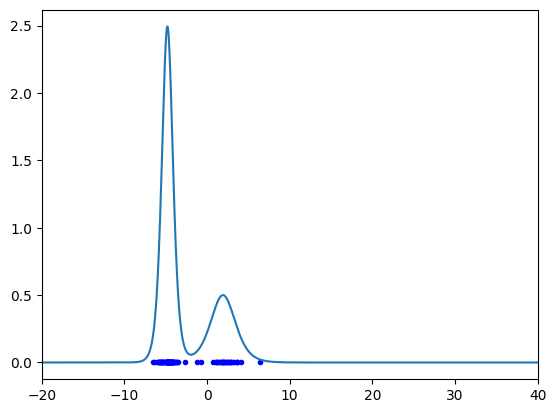

In [12]:
# Test AR method for the initial sampling from u

from scipy.stats import norm

def KdVWrapper(x):
    x = jnp.array([x])
    kdv = exactKdVTwoSol(x, 0)
    return kdv.squeeze()

n = 100 # number of samples
g = norm(loc=-5, scale=4.5) # proposal distribution
C = 29 # constant for AR
x_test = sample_from_function(KdVWrapper, g, C, n)

x_plot = jnp.linspace(problem_data.domain[0], problem_data.domain[1], problem_data.N)
plt.scatter(x_test, jnp.zeros(n), color='blue', marker='.')
plt.plot(x_plot, exactKdVTwoSol(x_plot, 0))
plt.xlim([problem_data.domain[0], problem_data.domain[1]])
# plt.ylim([-0.1, 2.7])
plt.show()

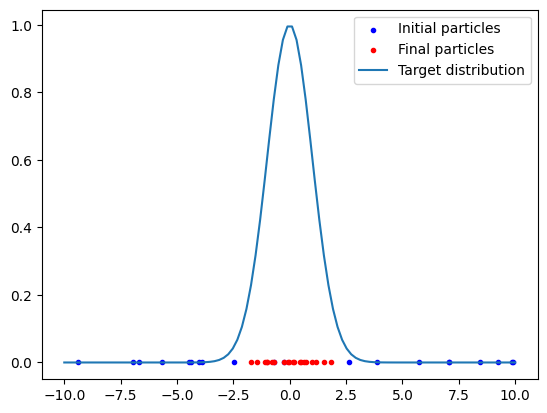

In [13]:
# Test SVGD on a simple Gaussian

@jax.jit
def gaussian(x, mu, sigma):
    return jnp.exp(- 0.5 * (x - mu) ** 2 / sigma ** 2)

@jax.jit
def log_gaussian(x, mu, sigma):
    return jnp.log(gaussian(x, mu, sigma))

@jax.jit
def log_gaussian_dx(x, mu, sigma):
    return jax.vmap(jax.grad(log_gaussian), (0, None, None))(x, mu, sigma)

x0 = jax.random.uniform(jax.random.key(0), shape=(20, ), minval=-10, maxval=10).reshape(-1, 1) # initial particles
dlnprob = lambda x: log_gaussian_dx(x, 0, 1)
theta = SVGD_update(x0, dlnprob, n_iter=500, stepsize=0.05, alpha=10, debug=True)

plt.scatter(x0, jnp.zeros_like(x0), color='blue', label='Initial particles', marker='.')
plt.scatter(theta, jnp.zeros_like(theta), color='red', label='Final particles', marker='.')
x_plot = jnp.linspace(-10, 10, 100)
plt.plot(x_plot, gaussian(x_plot, 0, 1), label='Target distribution')
plt.legend()
plt.show()

In [26]:
@jax.jit
def predictor_corrector(theta_flat, x, t):
    '''
    Predictor-corrector scheme based on forward Euler.
    '''
    return jnp.linalg.lstsq(M_fn(theta_flat, x), F_fn(theta_flat, x, t))[0]


def adaptive_sampling(theta_flat, problem_data, n, x, t):
    '''
    Adaptive sampling with SVGD.
    '''
    gamma = 0.25 # tempering parameter
    epsilon = 0.05 # step size
    steps = 500
    alpha = problem_data.dt / epsilon # scaling parameter

    # Predictor-corrector scheme
    # theta_flat_pred = predictor_corrector(theta_flat, x, t, problem_data.dt, M_fn, F_fn)
    delta_theta_flat = predictor_corrector(theta_flat, x, t)

    # The target measure is proportional to the residual scaled by a tempering parameter
    # mu = lambda y: jnp.abs(r_fn(theta_flat, theta_flat_pred - theta_flat, y, t)) ** (2 * gamma)
    mu = lambda y: jnp.abs(r_fn(theta_flat, delta_theta_flat, y, t)) ** (2 * gamma)
    log_mu = lambda y: jnp.log(mu(y)) # log(mu) = - V
    log_mu_dx = jax.vmap(jax.grad(log_mu), 0)

    x = SVGD_update(x, log_mu_dx, n_iter=steps, stepsize=epsilon, alpha=alpha)

    # Compute residual (for debugging)
    x_plot = jnp.linspace(problem_data.domain[0], problem_data.domain[1], problem_data.N)
    r = jax.vmap(r_fn, (None, None, 0, None))(theta_flat, delta_theta_flat, x_plot, t)

    return x, jnp.abs(r)

In [124]:
# @jax.jit
def system(x, t, theta_flat):
    M = M_fn(theta_flat, x)
    epsilon = 1e-3
    # print(jnp.linalg.cond(M + epsilon * jnp.eye(M.shape[0])))
    dx = jnp.linalg.solve(M + epsilon * jnp.eye(M.shape[0]), F_fn(theta_flat, x, t))[0]
    # dx = jnp.linalg.lstsq(M_fn(theta_flat, x), F_fn(theta_flat, x, t))[0]
    return dx


# @jax.jit
def runge_kutta_step(x, t, theta_flat, dt):
    k1 = system(x, t, theta_flat)
    k2 = system(x, t + 0.5 * dt, theta_flat + 0.5 * dt * k1)
    k3 = system(x, t + 0.5 * dt, theta_flat + 0.5 * dt * k2)
    k4 = system(x, t + dt, theta_flat + dt * k3)
    theta_flat_next = theta_flat + dt * (k1 + 2 * k2 + 2 * k3 + k4) / 6
    return theta_flat_next


def runge_kutta_scheme(theta_flat, problem_data, n, x, sampler):
    
    # Points for plotting and error evaluation
    x_plot = jnp.linspace(problem_data.domain[0], problem_data.domain[1], problem_data.N)
    
    solution = []
    timesteps = []
    
    t = 0
    temp_index = 0

    while t < problem_data.T:

        # Save current time and solution
        timesteps.append(t)
        u = U(theta_flat, x_plot.reshape(-1, 1))
        solution.append(u)

        # Sample points in the spatial domain
        if sampler == 'svgd':
            if temp_index % 10 == 0:
                # x = adaptive_sampling(theta_flat, problem_data, n, x, scheme.t, M_fn, F_fn, r_fn)
                x, r = adaptive_sampling(theta_flat, problem_data, n, x, t)
        elif sampler == 'uniform':
            x = uniform_sampling(problem_data, n, seed=int(t * 1e6))
        
        # Integration step
        theta_flat = runge_kutta_step(x, t, theta_flat, problem_data.dt)

        if sampler == 'svgd' and temp_index % 10 == 0:
            plot1 = plt.scatter(x, jnp.zeros(n), color='blue', marker='.')
            plot2 = plt.plot(x_plot, exactKdVTwoSol(x_plot, t))
            plot3 = plt.plot(x_plot, U(theta_flat, x_plot.reshape(-1, 1)))
            plot4 = plt.plot(x_plot, r)
            plt.xlim([-20, 40])
            plt.ylim([-0.5, 2.7])
            display(plot1)
            display(plot2)
            display(plot3)
            display(plot4)
            # time.sleep(0.001)
            clear_output(wait=True)
            plt.legend(['particles', 'exact', 'approx', 'residual'])
            plt.title(f't = {t:.5f}')
            plt.show()
        elif sampler == 'uniform' and temp_index % 10 == 0:
            plot1 = plt.plot(x_plot, exactKdVTwoSol(x_plot, t))
            plot2 = plt.plot(x_plot, U(theta_flat, x_plot.reshape(-1, 1)))
            plt.xlim([-20, 40])
            plt.ylim([-0.5, 2.7])
            display(plot1)
            display(plot2)
            clear_output(wait=True)
            plt.legend(['exact', 'approx'])
            plt.title(f't = {t:.5f}')
            plt.show()

        t += problem_data.dt
        temp_index += 1
        
    return solution, timesteps


# def runge_kutta_scheme(theta_flat, problem_data, n, x):
        
#     def rhs_RK45(t, theta_flat):
#         return jnp.linalg.lstsq(M_fn(theta_flat, x), F_fn(theta_flat, x, t))[0]

#     # Points for plotting and error evaluation
#     x_plot = jnp.linspace(problem_data.domain[0], problem_data.domain[1], problem_data.N)
    
#     solution = []
#     timesteps = []
    
#     scheme = scipy.integrate.RK45(rhs_RK45, 0, theta_flat, problem_data.T, max_step=problem_data.dt, rtol=1e-4) # should be constant step 1e-4!

#     temp_index = 0

#     while scheme.t < problem_data.T:

#         # print(f'  t = {scheme.t:.5f}')

#         # Sample points in the spatial domain
#         if temp_index % 10 == 0:
#             # x = adaptive_sampling(theta_flat, problem_data, n, x, scheme.t, M_fn, F_fn, r_fn)
#             x, r = adaptive_sampling(scheme.y, problem_data, n, x, scheme.t, M_fn, F_fn, r_fn)
#             # def KdVWrapper_t(x):
#             #     x = jnp.array([x])
#             #     kdv = exactKdVTwoSol(x, scheme.t)
#             #     return kdv.squeeze()
#             # x = sample_from_function(KdVWrapper_t, g, C, n).reshape(-1, 1)
        
#         # Integration step
#         scheme.step()
#         timesteps.append(scheme.t)

#         # Save current solution
#         u = U(scheme.y, x_plot.reshape(-1, 1))
#         solution.append(u)

#         if temp_index % 10 == 0:
#             plot1 = plt.scatter(x, jnp.zeros(n), color='blue', marker='.')
#             plot2 = plt.plot(x_plot, exactKdVTwoSol(x_plot, scheme.t))
#             plot3 = plt.plot(x_plot, U(scheme.y, x_plot.reshape(-1, 1)))
#             plot4 = plt.plot(x_plot, r)
#             plt.xlim([-20, 40])
#             plt.ylim([-0.5, 2.7])
#             display(plot1)
#             display(plot2)
#             display(plot3)
#             display(plot4)
#             # time.sleep(0.001)
#             clear_output(wait=True)
#             plt.legend(['particles', 'exact', 'approx', 'residual'])
#             plt.title(f't = {scheme.t:.5f}')
#             plt.show()

#         temp_index += 1
        
#     return solution, timesteps

In [22]:
def neural_galerkin(theta_flat, problem_data, n, sampler, scheme):

    print('Run time evolution...')

    # Initialize the particles by sampling from the initial condition
    if sampler == 'svgd':
        x_init = sample_from_function(KdVWrapper, g, C, n).reshape(-1, 1)
    elif sampler == 'uniform':
        x_init = uniform_sampling(problem_data, n)

    solution, timesteps = runge_kutta_scheme(theta_flat, problem_data, n, x_init, sampler)

    return solution, timesteps

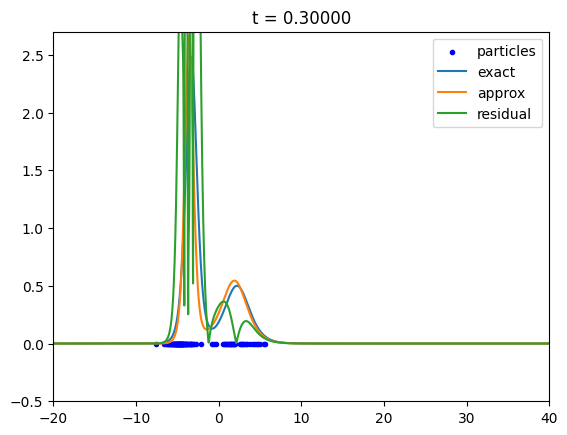

KeyboardInterrupt: 

In [69]:
solution, timesteps = neural_galerkin(theta_flat=theta_flat, # parameters
                           problem_data=problem_data, # problem data
                           n=100, # sample points
                           sampler='svgd', # sampling strategy
                           scheme='rk45' # ODE solver
                          )

In [ ]:
plot_solution(solution, timesteps, problem_data)

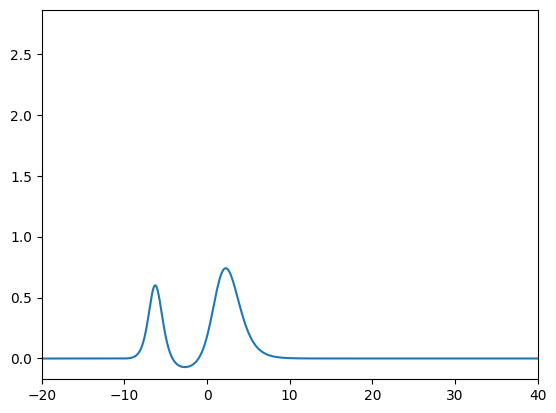

In [49]:
plot_animation(solution, timesteps, problem_data)

### Compute relative error

In [50]:
errors = compute_error(solution, timesteps, exactKdVTwoSol, problem_data)

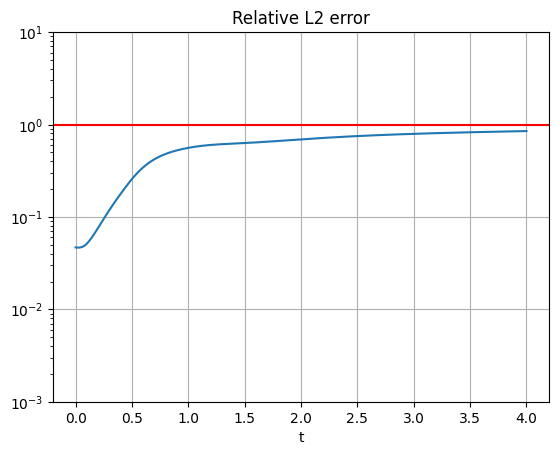

In [52]:
plot_error(errors, timesteps, 'Relative L2 error')

### Comparison with static sampling

In [103]:
theta = jnp.load('./data/theta_init_' + problem_data.name + '_' + str(training_data.seed) + '_improved.npy', allow_pickle=True).item()

In [104]:
net = DeepNetKdV(training_data.m)

In [105]:
theta_flat, unravel = jax.flatten_util.ravel_pytree(theta) # flatten a pytree of arrays down to a 1D array
u_fn = unraveler(net.apply, unravel) # auxiliary function that allows to evaluate the NN starting from the flattened parameters

# Define gradients
U = jax.vmap(u_fn, (None, 0)) # jax.vmap(fun, in_axes)
U_dtheta = jax.vmap(jax.grad(u_fn), (None, 0))
U_dx = jax.vmap(gradsqz(u_fn, 1), (None, 0))
U_dddx = jax.vmap(gradsqz(gradsqz(gradsqz(u_fn, 1), 1), 1), (None, 0))

In [125]:
# Source term for the KdV equation
def rhs(theta_flat, x, t):
    assert(len(x.shape) == 2)
    u = U(theta_flat, x)
    u_x = U_dx(theta_flat, x)
    u_xxx = U_dddx(theta_flat, x)
    return - u_xxx - 6 * u * u_x


@jax.jit
def M_fn(theta_flat, x):
    '''
    Assemble the M matrix (with boundary correction).
    '''
    assert(len(x.shape) == 2)
    u_dth = U_dtheta(theta_flat, x)
    M = jnp.mean(u_dth[:, :, jnp.newaxis] * u_dth[:, jnp.newaxis, :], axis=0)
    
    zeta = 10000
    x_lower, x_upper = jnp.array(problem_data.domain[0]).reshape(-1, 1), jnp.array(problem_data.domain[1]).reshape(-1, 1)
    u_dth_lower, u_dth_upper = U_dtheta(theta_flat, x_lower), U_dtheta(theta_flat, x_upper)
    # u_dth_mean = jnp.mean(u_dth, axis=0).reshape(-1, 1)
    # B_lower, B_upper = u_dth_lower * u_dth_mean, u_dth_upper * u_dth_mean
    B_lower, B_upper = u_dth_lower * u_dth_lower.reshape(-1, 1), u_dth_upper * u_dth_upper.reshape(-1, 1)
    B = zeta * (B_lower + B_upper)
    return M + B


@jax.jit
def F_fn(theta_flat, x, t):
    '''
    Assemble the F matrix.
    '''
    assert(len(x.shape) == 2)
    u_dth = U_dtheta(theta_flat, x)
    f = rhs(theta_flat, x, t) # source term
    F = jnp.mean(u_dth[:, :] * f[:, jnp.newaxis], axis=0)
    return F

In [126]:
solution_static, timesteps_static = neural_galerkin(theta_flat=theta_flat, # parameters
                                                    problem_data=problem_data, # problem data
                                                    n=1000, # sample points
                                                    sampler='uniform', # sampling strategy
                                                    scheme='rk45' # ODE solver
                                                   )

KeyboardInterrupt: 

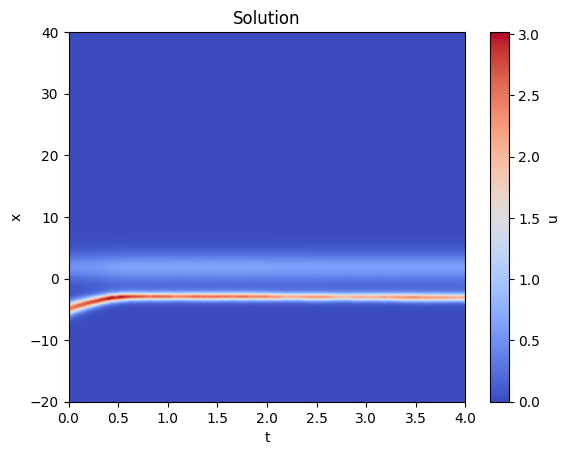

In [38]:
plot_solution(solution_static, timesteps_static, problem_data)

In [105]:
errors_static = compute_error(solution_static, timesteps_static, exactKdVTwoSol, problem_data)

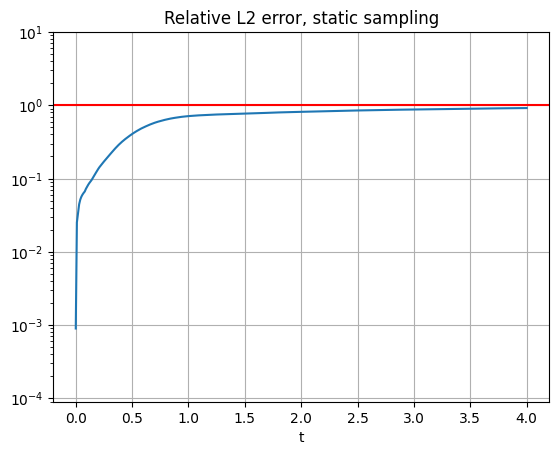

In [106]:
plot_error(errors_static, timesteps_static, 'Relative L2 error, static sampling')